## Creating a discharge distribution using the methods of Lague et al., 2005

This paper uses a daily discharge distribution from a stream gauge to create a frequency-magnitude distribution. The distribution is a power-law distribution that they vary the length and shape of the tail to produce different degrees of discharge variability. Roman recommended this to me to builde the discharge curves for my NST model runs https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2004JF000259

#### Step 1: Import the data

In [50]:
import pandas as pd
import numpy as np
import math 
from distfit import distfit
import scipy.stats as st
import matplotlib as mpl
import matplotlib.pyplot as plt

from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)



In [2]:
q = pd.read_excel('/Users/safiya/Desktop/MethowGaugeData.xlsx', sheet_name = 'daily', header = 0)

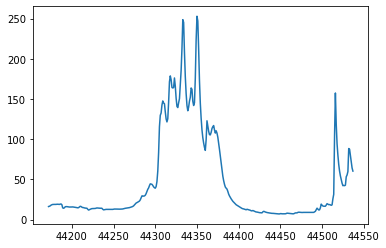

In [3]:
plt.plot(q['day'], q['discharge'])

In [4]:
mq =np.average(q['discharge']) ## mean discharge 

In [5]:
qvals = q['discharge'].to_numpy() ## extract the discharges only

In [6]:
qdist =  distfit(distr='expon', bins = 25, alpha = 0.02, stats ='ks')

In [7]:
qdist.fit_transform(qvals, verbose=1)

{'model': {'distr': <scipy.stats._continuous_distns.expon_gen at 0x7ffe5e55f940>,
  'stats': 'ks',
  'params': (7.0792, 39.27275662417583),
  'name': 'expon',
  'model': <scipy.stats._distn_infrastructure.rv_frozen at 0x7ffe5efdd8e0>,
  'score': 0.32289194958004,
  'loc': 7.0792,
  'scale': 39.27275662417583,
  'arg': (),
  'CII_min_alpha': 7.8726160076303975,
  'CII_max_alpha': 160.71512740035644},
 'summary':    distr     score  LLE     loc      scale arg
 0  expon  0.322892  NaN  7.0792  39.272757  (),
 'histdata': (array([0.05281248, 0.01201554, 0.0036326 , 0.00558862, 0.00195602,
         0.00167659, 0.00083829, 0.00111772, 0.00223545, 0.00139716,
         0.00251488, 0.00195602, 0.00167659, 0.00251488, 0.00279431,
         0.00195602, 0.00139716, 0.00111772, 0.00027943, 0.        ,
         0.00083829, 0.        , 0.00027943, 0.        , 0.00111772]),
  array([ 11.99499648,  21.82658944,  31.6581824 ,  41.48977536,
          51.32136832,  61.15296128,  70.98455424,  80.8161472 ,


(<Figure size 720x576 with 1 Axes>,
 <AxesSubplot:title={'center':'\nexpon\nloc=7.08, scale=39.27'}, xlabel='Values', ylabel='Frequency'>)

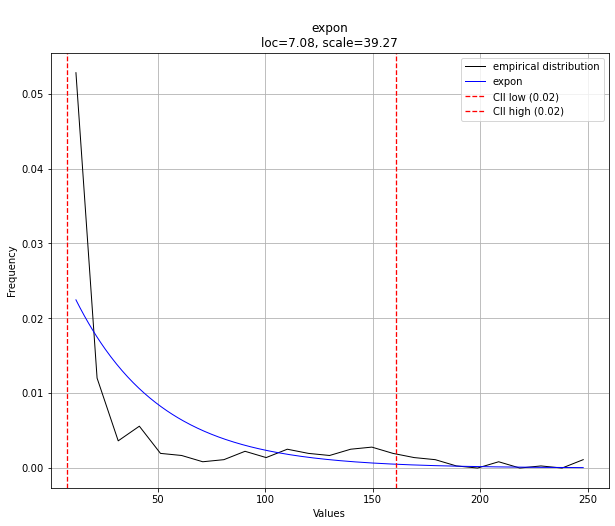

In [8]:
qdist.plot(verbose=1)

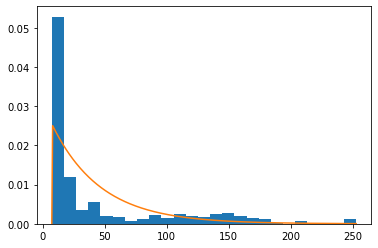

In [9]:
x = np.linspace(qvals.min(), qvals.max(), len(qvals))

#y = st.beta.pdf(x, a=0.50, b=7.12, loc=7.08, scale=553)
y = st.expon.pdf(x, loc=7.08, scale=39.27)
plt.hist(qvals, bins = 25, density=True)
plt.plot(x, y)

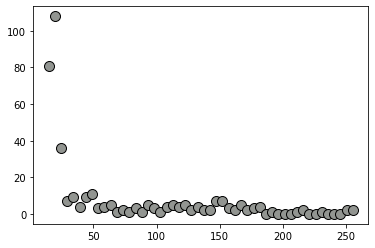

In [10]:
bins, binedges = np.histogram(q['discharge'], bins = 50)
binc = binedges[1:]+0.5*(binedges[1]-binedges[0])
plt.plot(binc, bins, marker = 'o', ms = 10, lw = 0, mfc = 'xkcd:grey', mec = 'k')

# Doing it over using monthly discharges

In [11]:
all_data = pd.read_excel('/Users/safiya/Desktop/MethowGaugeData.xlsx', sheet_name = 'month-consol', header = 0, usecols='A:M')

In [12]:
qravel = (all_data.iloc[:, 1:].to_numpy().ravel())*0.0283168 ## flatten all the data into one array, converted to m3/s

Now lets do some statistics

(<Figure size 720x576 with 1 Axes>,
 <AxesSubplot:title={'center':'\nexpon\nloc=6.67, scale=37.78'}, xlabel='Values', ylabel='Frequency'>)

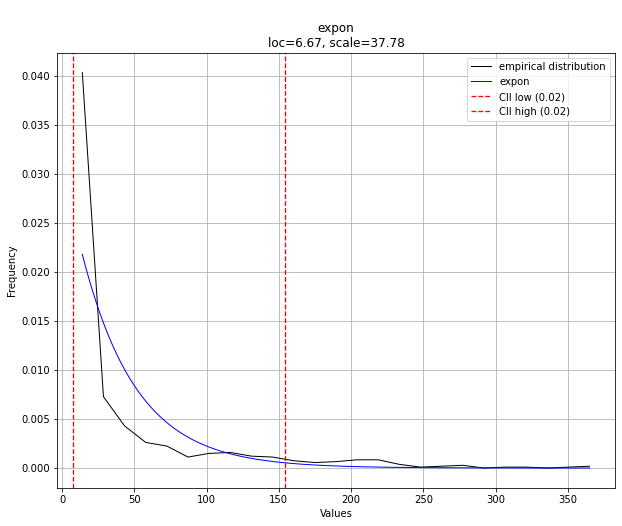

In [13]:
qdist_all = distfit(distr='expon', bins = 25, alpha = 0.02, stats ='ks')
qdist_all.fit_transform(qravel, verbose = 1)
qdist_all.plot(verbose=1)

Create the PDF

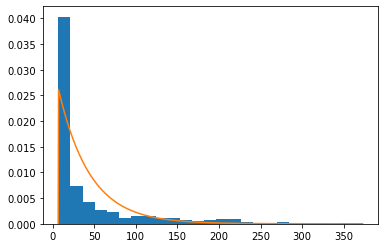

In [14]:
x = np.linspace(qravel.min(), qravel.max(), len(qravel))

#y = st.beta.pdf(x, a=0.63, b=59.75, loc=6.67, scale=4010.08)
y = st.expon.pdf(x, loc=6.67, scale=37.78)
plt.hist(qravel, bins = 25, density=True)
plt.plot(x, y)

Construfting the discharges in this code then just exporting them to NST

calibrating DVIa:
1. low = 0.5, in paper it's <1
1. moderate 1.5, in paper it's 1-2
1. high = 3, in paper it's >2

In [15]:
driestmo = qravel.min()
real_wettestmo = qravel.max()
real_dvia = (real_wettestmo-driestmo)/(np.average(qravel))
mq = np.average(qravel)
print('DVIa for real Methow Gauge Data is: ', real_dvia)



DVIa for real Methow Gauge Data is:  8.227603846278372


In [16]:
makedvia = np.array([0.5, 1.5])
new_wettest = (makedvia*mq)/driestmo
print('New wettest discharges are: ', new_wettest)

New wettest discharges are:  [ 3.33404251 10.00212753]


Now we have to make the distribution of discharges, but we want to maintain the shape...and the loc...not really sure what to change here but we'll just play with a couple things

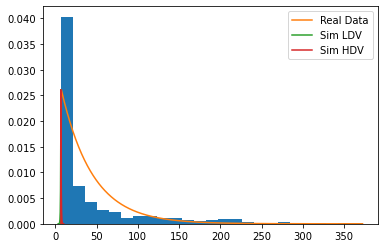

In [17]:
## varying the range of x values (so the discharge, but keeping the number of values the same)
lowx = np.linspace(qravel.min(), new_wettest[0], len(qravel))
#lowy =  st.beta.pdf(x, a=0.63, b=59.75, loc=6.67, scale=4010.08)
lowy = st.expon.pdf(x, loc=6.67, scale=37.78)
modx = np.linspace(qravel.min(), new_wettest[1], len(qravel))
#mody =  st.beta.pdf(x, a=0.63, b=59.75, loc=6.67, scale=4010.08)
mody = st.expon.pdf(x, loc=6.67, scale=37.78)
plt.hist(qravel, bins = 25, density=True)
plt.plot(x, y, label = 'Real Data')
plt.plot(lowx, lowy, label = 'Sim LDV')
plt.plot(modx, mody, label = 'Sim HDV')
plt.legend()

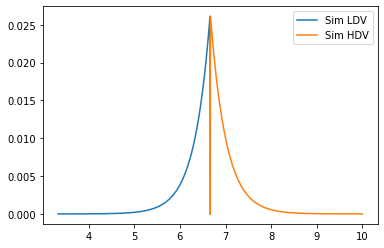

In [18]:
plt.plot(lowx, lowy, label = 'Sim LDV')
plt.plot(modx, mody, label = 'Sim HDV')
plt.legend()

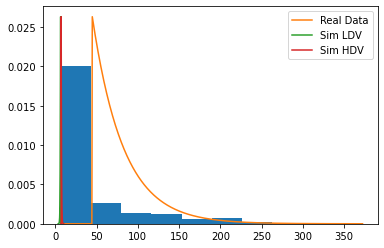

In [19]:
## using the actual mean as the mean, not their loc
y = st.expon.pdf(x, loc=mq, scale=37.78)
lowx = np.linspace(qravel.min(), new_wettest[0], len(qravel))
#lowy =  st.beta.pdf(x, a=0.63, b=59.75, loc=6.67, scale=4010.08)
lowy = st.expon.pdf(x, loc=mq, scale=37.78)
modx = np.linspace(qravel.min(), new_wettest[1], len(qravel))
#mody =  st.beta.pdf(x, a=0.63, b=59.75, loc=6.67, scale=4010.08)
mody = st.expon.pdf(x, loc=mq, scale=37.78)
plt.hist(qravel, bins = 10, density=True)
plt.plot(x, y, label = 'Real Data')
plt.plot(lowx, lowy, label = 'Sim LDV')
plt.plot(modx, mody, label = 'Sim HDV')
plt.legend()

#### Using daily discharge data from the last 60 years

In [51]:
qday = pd.read_excel('/Users/safiya/Desktop/MethowGaugeData.xlsx', sheet_name = 'daily1959', header = 0) ##1960-2020, 61 years, no leap days

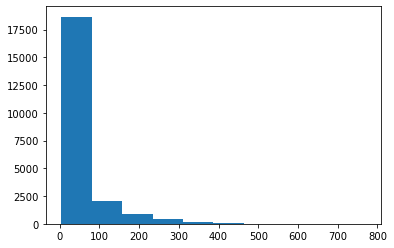

In [52]:
qday_q = qday['Discharge'].to_numpy()
qday_q = qday_q*0.0283168
qday_q = np.delete(qday_q, np.where(np.isnan(qday_q)))
plt.hist(qday_q);

In [53]:
## get a random year to calibrate to
year = np.random.randint(1960, 2020)
print(year)

1998


In [54]:
data1 = qday_q[(year-1960):(year-1960)+366]
dist1 = distfit(distr='gamma',bins = 25, alpha = 0.02, stats = 'ks')

## alpha = significance alpha
## stats = 
##fit to the data
dist1.fit_transform(data1, verbose=1)

{'model': {'distr': <scipy.stats._continuous_distns.gamma_gen at 0x7f8187cbd580>,
  'stats': 'ks',
  'params': (0.5753737933822576, 7.645535999999999, 54.82353010433424),
  'name': 'gamma',
  'model': <scipy.stats._distn_infrastructure.rv_frozen at 0x7f816e408070>,
  'score': 0.5450909183831959,
  'loc': 7.645535999999999,
  'scale': 54.82353010433424,
  'arg': (0.5753737933822576,),
  'CII_min_alpha': 7.695571448472102,
  'CII_max_alpha': 167.2475209501535},
 'summary':    distr     score  LLE       loc     scale                    arg
 0  gamma  0.545091  NaN  7.645536  54.82353  (0.5753737933822576,),
 'histdata': (array([0.05411234, 0.00384799, 0.0012025 , 0.00432899, 0.00480999,
         0.00192399, 0.00288599, 0.00216449, 0.00288599, 0.0016835 ,
         0.00216449, 0.0007215 , 0.0002405 , 0.0002405 , 0.0002405 ,
         0.000481  , 0.000481  , 0.0007215 , 0.        , 0.0007215 ,
         0.0002405 , 0.        , 0.0012025 , 0.0002405 , 0.000481  ]),
  array([ 13.32588608,  24.68

In [7]:
nyears = 1

yeardata = qday_q[(year-1960):(year-1960)+366]
wettest=yeardata.max()
driest = yeardata.min()
meanannual= np.average(yeardata)
print('driest', driest)
print('wettest', wettest)
print('meanannual', meanannual)

mr_dviy = ((wettest-driest)/meanannual)
print(f'DVIy for Methrow River in {year} is:', mr_dviy)

driest 7.645536
wettest 291.66304
meanannual 44.563834789071045
DVIy for Methrow River in 1987 is: 6.3732734255098995


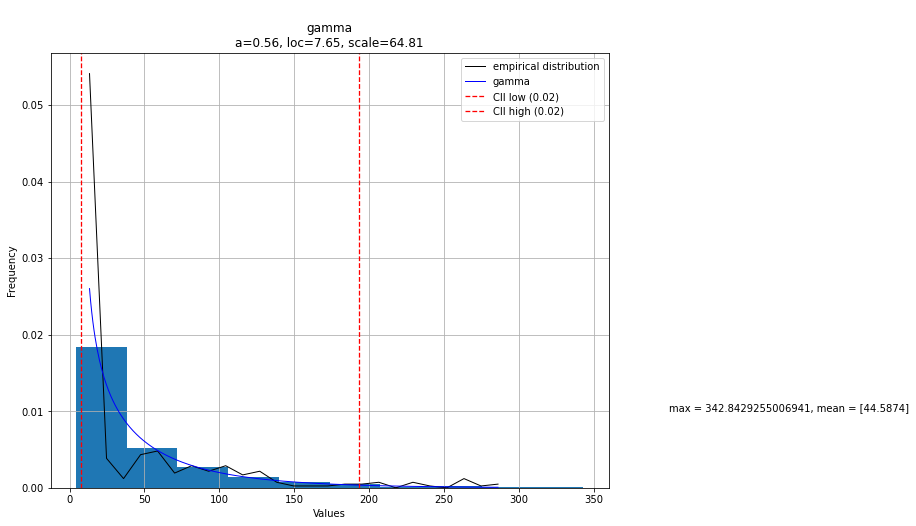

In [8]:
dist1.plot(verbose=1)
sc = 58.46
a = [0.69]
loc= 4.25
distro = st.gamma.rvs(a, loc, sc, size=365)
meandist = st.gamma.mean(a, loc, scale=sc)
stddev = st.gamma.std(a, loc, scale=sc)
plt.hist(distro, density=True);
plt.text(400,0.010, s=f'max = {distro.max()}, mean = {meandist}');

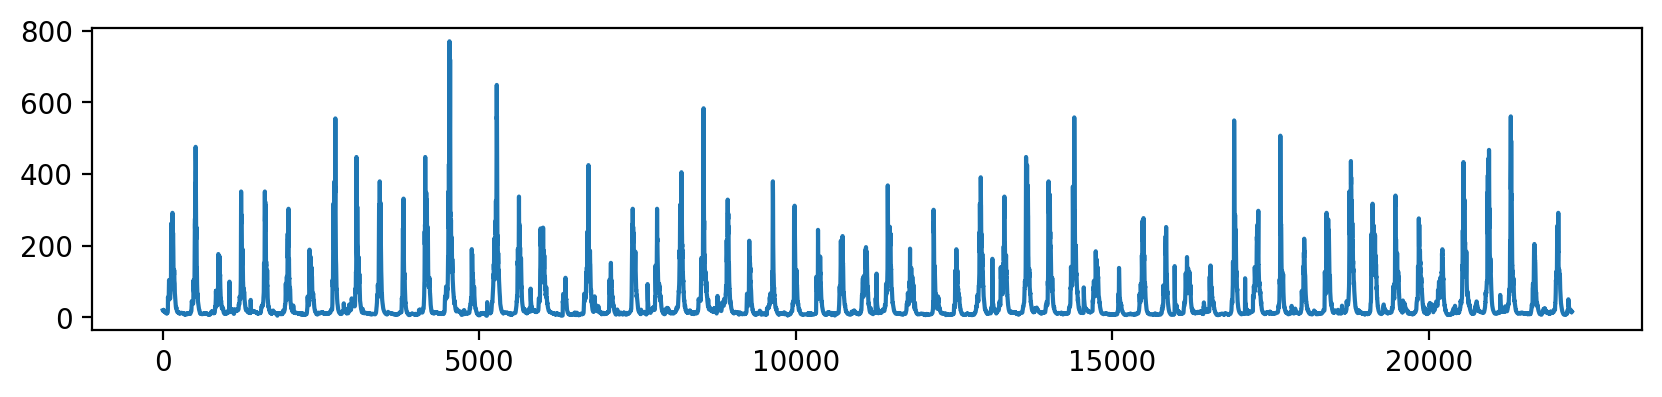

In [57]:
plt.figure(figsize = (10, 2), dpi=200)
plt.plot(np.arange(0, len(qday_q)), qday_q)
#plt.stem(qday_q)

Okay, change enntirely, we are looking at the range of discharge variability over the basin but looking at years that have all three DV scenarios bc this basin is so variable. This way we do not have to statsistically parameterise any discharge and I dcan have a large portion of my mental space back. So the procedure is as follows: 
1. calculate dviy for every year on record
2. sort by dviy values...like bin the years of something
3. randomly sample from each of those year bins and use that discharge data to calibrate the model

capiche? capoosh.

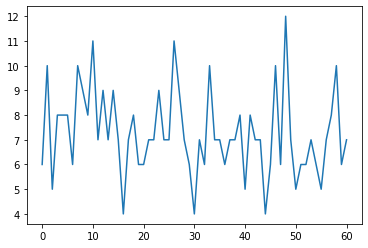

In [6]:
nyears = abs(1960-2021) ## number of years on record, each year will have a value for discharge 
wettest = np.empty([nyears])
driest = np.empty([nyears])
mean_annual = np.empty([nyears])
dviy = np.empty([nyears])

for i in range (0, nyears):
    sample = qday_q[(i*365):((i+1)*365)+1] ## get the annual sample
    wettest[i] = sample.max()
    driest[i] = sample.min()
    mean_annual[i] = np.mean(sample)
    dviy[i] = np.round((wettest[i]-driest[i])/mean_annual[i], 0)

plt.plot(np.arange(0, 61), dviy)
#plt.plot(np.arange(0, 61), wettest)
#plt.plot(np.arange(0, 61), dviy)
#plt.plot(np.arange(0, 61), dviy)

In [44]:
np.where(dviy <= np.quantile(dviy, 0.01))

(array([16, 30, 44]),)

In [7]:
vals, counts = np.unique(dviy, return_counts=True)
index = np.argmax(counts)
dvi_min = dviy.min()
dvi_mode = vals[index]
dvi_max = dviy.max()

In [ ]:
np.random.choice

In [48]:
## find three random years
minyear = np.random.choice(np.where(dviy <= np.quantile(dviy, 0.01))[0], 3, replace=False)
minyear_q = np.concatenate((qday_q[(minyear[0]*365):(minyear[0]*365)+366], 
                           qday_q[(minyear[1]*365):(minyear[1]*365)+366], 
                           qday_q[(minyear[2]*365):(minyear[2]*365)+366]))
                             
modeyear = np.random.choice(np.where(dviy == dvi_mode)[0], 3, replace=False)
modeyear_q = np.concatenate((qday_q[(modeyear[0]*365):(modeyear[0]*365)+366], 
                           qday_q[(modeyear[1]*365):(modeyear[1]*365)+366], 
                           qday_q[(modeyear[2]*365):(modeyear[2]*365)+366]))
                             
maxyear = np.random.choice(np.where(dviy >= np.quantile(dviy, 0.95))[0], 3, replace=False)
maxyear_q = np.concatenate((qday_q[(maxyear[0]*365):(maxyear[0]*365)+366], 
                           qday_q[(maxyear[1]*365):(maxyear[1]*365)+366], 
                           qday_q[(maxyear[2]*365):(maxyear[2]*365)+366]))
                       
# randpicks = np.random.choice(dviy, 3)
# print(randpicks)
# random_combo = np.where(dviy==randpicks)
# print(random_combo)
# maxyear_q = np.concatenate((qday_q[(random_combo[0]*365):(random_combo[0]*365)+366], 
#                            qday_q[(random_combo[1]*365):(random_combo[1]*365)+366], 
#                            qday_q[(random_combo[2]*365):(random_combo[2]*365)+366]))
                        
print('Minimum discharge for NST at: ', minyear+1960)
print('Mode discharge variability for NST at: ', modeyear+1960)
print('Maximum discharge variability for NST at: ', maxyear+1960)
# print('Random sample of discharge variability for NST at: ', random_combo+1960, ' DV vals = ', random_combo)

Minimum discharge for NST at:  [1990 2004 1976]
Mode discharge variability for NST at:  [2009 1971 1994]
Maximum discharge variability for NST at:  [1961 2018 1986]


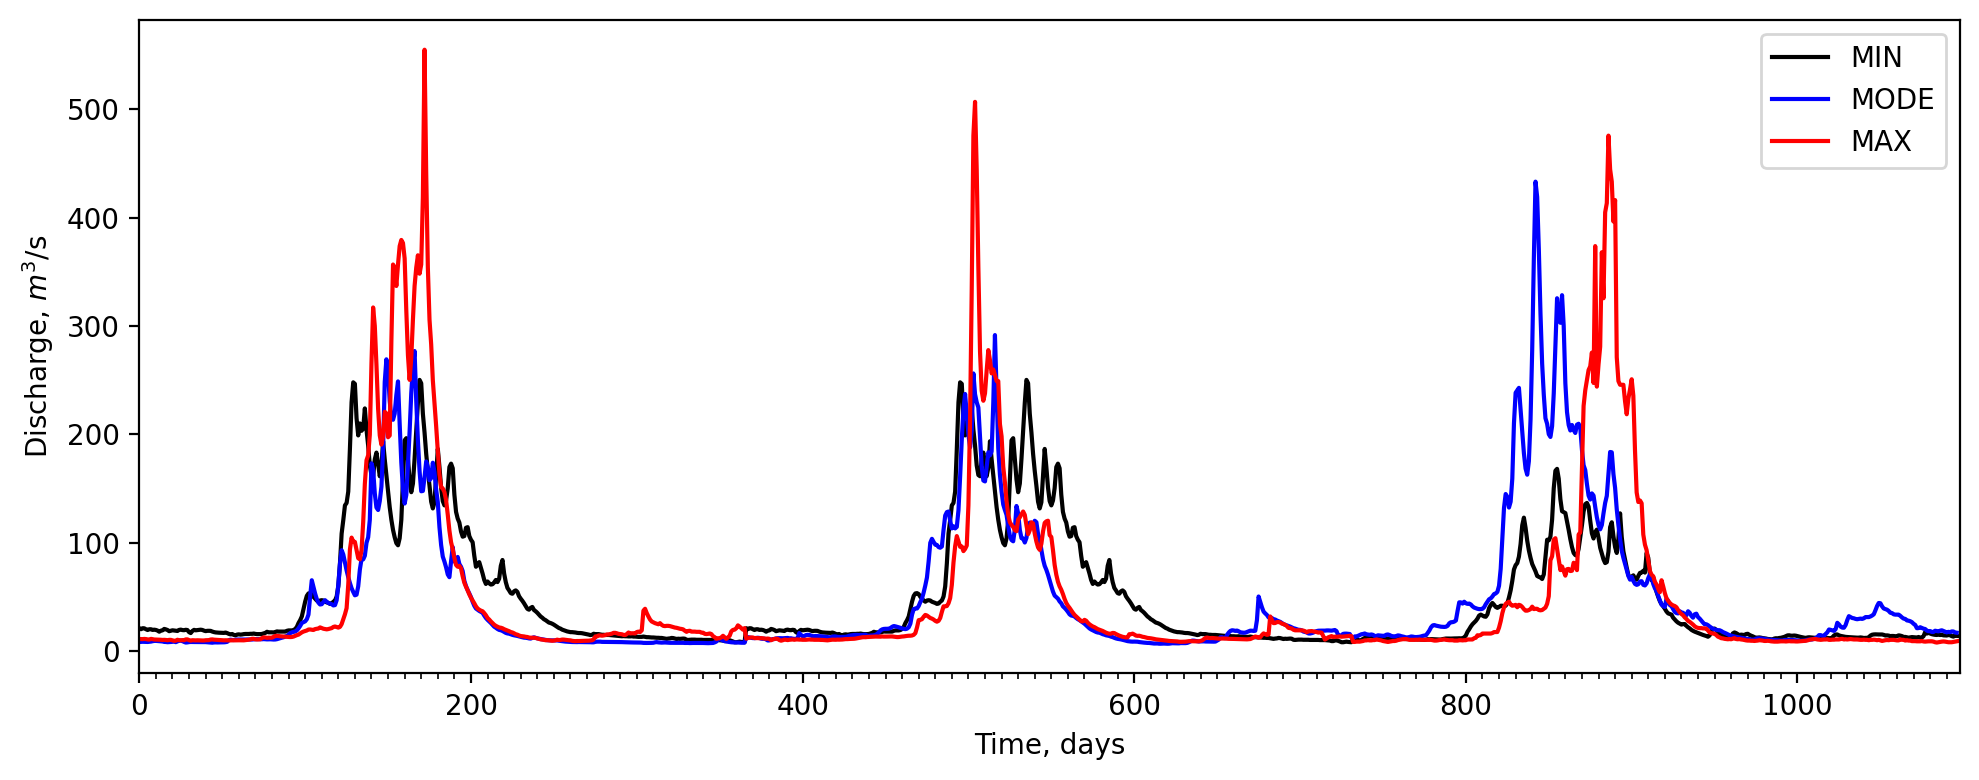

In [42]:
plt.figure(figsize = (10, 4), dpi =200, tight_layout = True)
plt.plot(np.arange(len(minyear_q)), minyear_q, label='MIN', c ='k')
plt.plot(np.arange(len(modeyear_q)), modeyear_q, label='MODE', c = 'b')
plt.plot(np.arange(len(maxyear_q)), maxyear_q, label='MAX', c = 'r')
plt.legend()
plt.xlim(0, 366*3)
plt.xlabel('Time, days')
plt.ylabel('Discharge, $m^3$/s')
ax = plt.gca()
ax.xaxis.set_minor_locator(MultipleLocator(10))
plt.savefig('/Users/safiya/Desktop/NST/dischargehydro.png')

array([16, 16, 44])

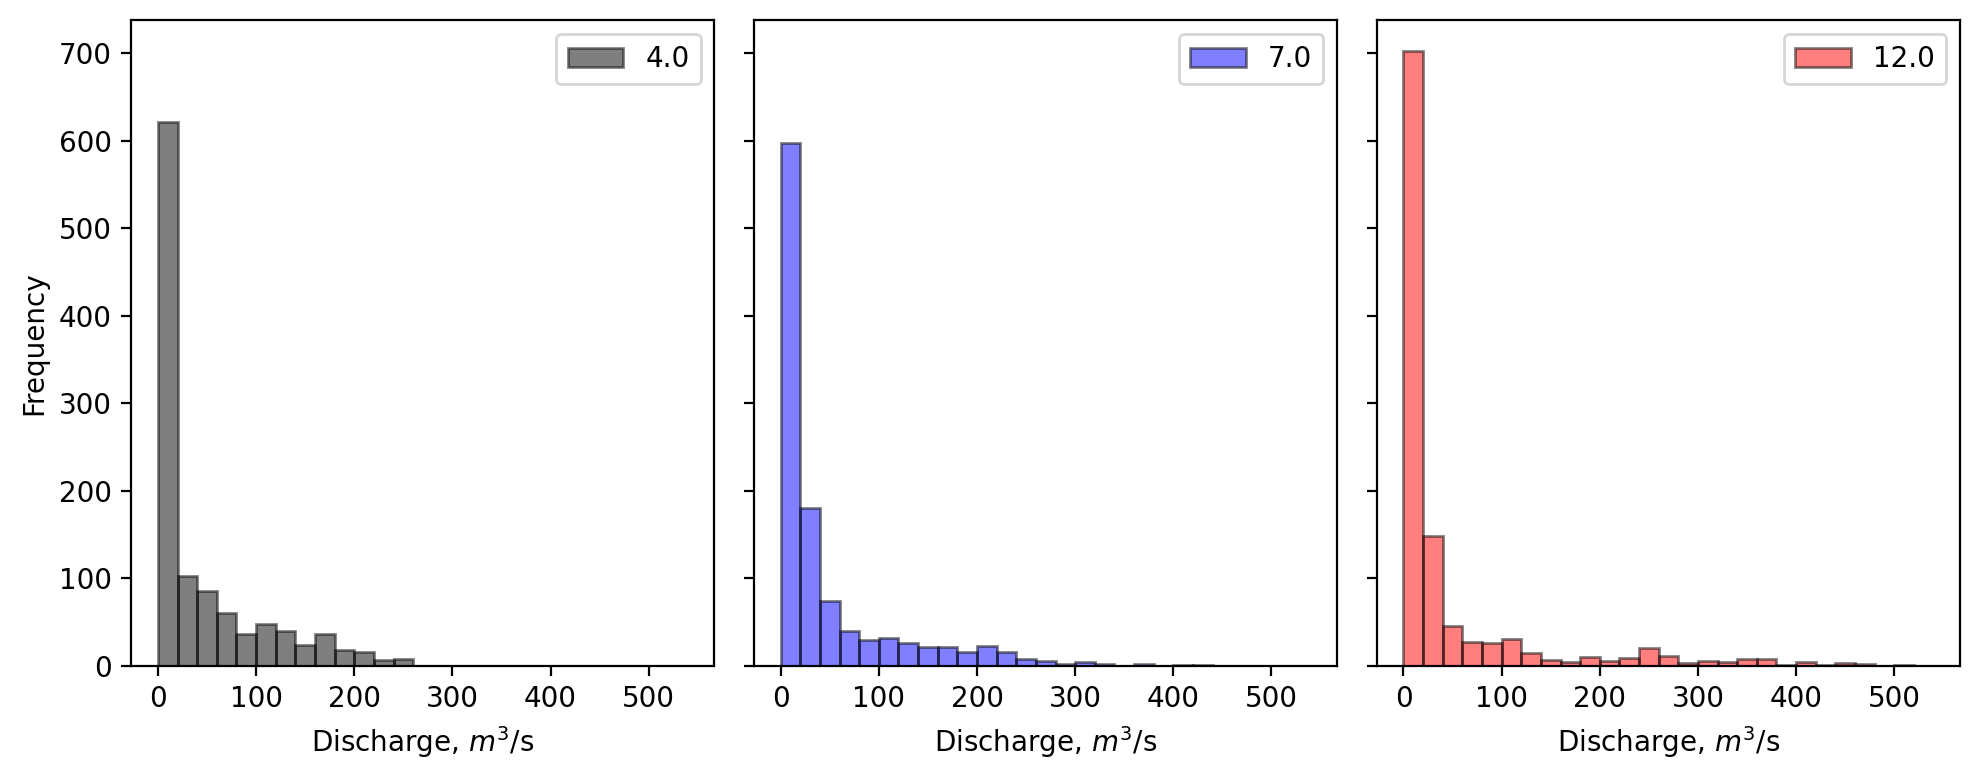

In [38]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (10, 4), dpi =200, tight_layout = True, sharey=True, sharex = True)
bins = np.arange(0, maxyear_q.max(), 20)
ax1.hist(minyear_q, label=dvi_min, fc ='k', ec = 'k', alpha = 0.5, bins = bins)
ax2.hist(modeyear_q, label=dvi_mode,fc ='b', ec = 'k', alpha = 0.5, bins = bins)
ax3.hist(maxyear_q, label=dvi_max,fc ='r', ec = 'k', alpha = 0.5, bins = bins)
ax1.set_ylabel('Frequency')

for ax in (ax1, ax2, ax3):
    ax.set_xlabel('Discharge, $m^3$/s')
    ax.legend()
plt.savefig('/Users/safiya/Desktop/NST/dischargehistos.png')

In [37]:
np.save('/Users/safiya/Desktop/minDV.npy', minyear_q)
np.save('/Users/safiya/Desktop/modeDV.npy', modeyear_q)
np.save('/Users/safiya/Desktop/maxDV.npy', maxyear_q)

In [55]:
st.mode(qday_q)

ModeResult(mode=array([10.194048]), count=array([173]))